# **MovieLens Recommendation With Actor Critic**

Reference : https://arxiv.org/pdf/1801.00209.pdf

## **1. Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import itertools
import random
import csv

# — TF-1.x compatibility mode —
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.nn.rnn_cell import GRUCell

## **2. MovieLens Data Preprocessing**

### Preprocessing the MovieLens dataset

1. **Load & merge data:** Read ratings (`userId,itemId,rating,timestamp`) and movie titles (`itemId|title`), then merge on `itemId`.  
2. **One event per row:** Ensure each row is a single `(user, movie, rating, timestamp)` record.  
3. **Chronological histories:** Group by `userId` and sort each user’s ratings from the oldest to newest.  
4. **User-disjoint split:** Shuffle users and partition their histories into train vs. test so no user overlaps.  
5. **Sample state–action pairs:** For each history, split at a ratio (e.g. 80/20), then draw random subsamples (with replacement if needed) from the “past” and “future” segments.  
6. **Export CSV:** Write rows with three columns—`state`, `action_reward`, and `n_state`—each formatted as `itemId&rating` entries joined by `|`.  

In [3]:
class DataGenerator():

  def __init__(self, path_to_data, path_to_item):
    '''
    Get the Movie lens data with the list of users, the movies(items) and their history
    '''
    self.data  = self.load_data(path_to_data, path_to_item)
    self.users = self.data['userId'].unique()   
    self.items = self.data['itemId'].unique()   
    self.histo = self.generate_history_funtion()
    self.train = []
    self.test  = []

  def load_data(self, path_to_data, path_to_item):
    '''
    Load the data
    '''
    data = pd.read_csv(path_to_data, sep='\t', 
                       names=['userId', 'itemId', 'rating', 'timestamp'])
    movie_titles = pd.read_csv(path_to_item, sep='|', names=['itemId', 'itemName'],
                           usecols=range(2), encoding='latin-1')
    return data.merge(movie_titles,on='itemId', how='left')


  def generate_history_funtion(self):
    '''
    Group all rates given by users and store them from older to most recent based on time.
    '''
    historic_users = []
    for i, u in enumerate(self.users):
      temp = self.data[self.data['userId'] == u]
      temp = temp.sort_values('timestamp').reset_index()
      temp.drop('index', axis=1, inplace=True)
      historic_users.append(temp)
    return historic_users

  def sample_history(
    self,
    user_histo,
    action_ratio=0.8,
    max_samp_by_user=5,
    max_state=100,
    max_action=50,
    nb_states=None,
    nb_actions=None,
  ):
    """
    Making multiple samples for a given historic set, based on some number of states and actions.
    Returns lists of (state_strings), (action_strings).
    """
    n   = len(user_histo)
    sep = int(action_ratio * n)
    # how many separate samples we’ll generate
    nb_sample = random.randint(1, max_samp_by_user)

    # if not provided, randomly choose sizes
    if nb_states is None:
        nb_states = [min(random.randint(1, sep), max_state) for _ in range(nb_sample)]
    if nb_actions is None:
        nb_actions = [min(random.randint(1, n - sep), max_action) for _ in range(nb_sample)]

    assert len(nb_states) == len(nb_actions), "nb_states and nb_actions must align"

    states, actions = [], []
    for s_size, a_size in zip(nb_states, nb_actions):
        # split pools
        state_pool  = user_histo.iloc[:sep]
        action_pool = user_histo.iloc[sep:]

        # decide if we need replacement
        replace_s = len(state_pool)  < s_size
        replace_a = len(action_pool) < a_size

        # sample
        sample_states  = state_pool.sample(n=s_size,  replace=replace_s)
        sample_actions = action_pool.sample(n=a_size, replace=replace_a)

        # format as "itemId&rating"
        states.append([
            f"{row.itemId}&{row.rating}"
            for _, row in sample_states.iterrows()
        ])
        actions.append([
            f"{row.itemId}&{row.rating}"
            for _, row in sample_actions.iterrows()
        ])

    return states, actions


  def get_train_test_split(self, test_ratio, seed=None):
    '''
    Create train and test datasets
    '''
    n = len(self.histo)

    if seed is not None:
      random.Random(seed).shuffle(self.histo)
    else:
      random.shuffle(self.histo)

    self.train = self.histo[:int((test_ratio * n))]
    self.test  = self.histo[int((test_ratio * n)):]
    self.user_train = [h.iloc[0,0] for h in self.train]
    self.user_test  = [h.iloc[0,0] for h in self.test]
    

  def write_csv(self, filename, histo_to_write, delimiter=';', action_ratio=0.8, max_samp_by_user=5, max_state=100, max_action=50, nb_states=[], nb_actions=[]):
    
    with open(filename, mode='w') as file:
      f_writer = csv.writer(file, delimiter=delimiter)
      f_writer.writerow(['state', 'action_reward', 'n_state'])
      for user_histo in histo_to_write:
        states, actions = self.sample_history(user_histo, action_ratio, max_samp_by_user, max_state, max_action, nb_states, nb_actions)
        for i in range(len(states)):
          # FORMAT STATE
          state_str   = '|'.join(states[i])
          # FORMAT ACTION
          action_str  = '|'.join(actions[i])
          # FORMAT N_STATE
          n_state_str = state_str + '|' + action_str
          f_writer.writerow([state_str, action_str, n_state_str])


## **3. Generating Embeddings for Movies**

### Generate Embedding vector for each movie item

1. Embedding vector created for each movie based on the context

2. The embeddings are learnt by training a sequential neural network model, where the weight of hidden states will give the output embeddings

3. Training steps :
    1. Context: a set of historic movies rated for a user with 1 random movie removed
    2. Target: the removed movie from historic list
    3. For multiple targets and its corresponding contexts, the embedding for the target movie is created
    4. Therefore, after training,  each movie gets a corresponding vector representation based the context of occurrence

4. Embeddings of each movie is obtained and saved into a file

In [4]:
class EmbeddingsGenerator:

  def  __init__(self, train_users, data):
    self.train_users = train_users

    self.data = data.sort_values(by=['timestamp'])
   
    self.data['userId'] = self.data['userId'] - 1
    self.data['itemId'] = self.data['itemId'] - 1

    self.user_count = self.data['userId'].max() + 1
    self.movie_count = self.data['itemId'].max() + 1

    self.user_movies = {} #list of rated movies by each user
    for userId in range(self.user_count):
      self.user_movies[userId] = self.data[self.data.userId == userId]['itemId'].tolist()
    self.m = self.define_model()

  def define_model(self, hidden_layer_size=100):
    # adding required layers
    m = Sequential()
    m.add(Dense(hidden_layer_size, input_shape=(1, self.movie_count)))
    m.add(Dropout(0.2))
    m.add(Dense(self.movie_count, activation='softmax'))
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return m
  
  def generate_input(self, user_id):
    '''
    Returns a context and a target for the user_id
    '''
    user_movies_count = len(self.user_movies[user_id])
    # picking random movie
    random_index = np.random.randint(0, user_movies_count-1) # -1 avoids taking the last movie
    # set target
    target = np.zeros((1, self.movie_count))
    target[0][self.user_movies[user_id][random_index]] = 1
    # set context
    context = np.zeros((1, self.movie_count))
    context[0][self.user_movies[user_id][:random_index] + self.user_movies[user_id][random_index+1:]] = 1
    return context, target

  def train(self, nb_epochs = 300, batch_size = 10000):
    '''
    Trains the model from train_users's history
    '''
    for i in range(nb_epochs):
      print('%d/%d' % (i+1, nb_epochs))
      batch = [self.generate_input(user_id=np.random.choice(self.train_users) - 1) for _ in range(batch_size)]
      X_train = np.array([b[0] for b in batch])
      y_train = np.array([b[1] for b in batch])
      self.m.fit(X_train, y_train, epochs=1, validation_split=0.5)

  def test(self, test_users, batch_size = 100000):
    '''
    Returns on the test set
    '''
    batch_test = [self.generate_input(user_id=np.random.choice(test_users) - 1) for _ in range(batch_size)]
    X_test = np.array([b[0] for b in batch_test])
    y_test = np.array([b[1] for b in batch_test])
    return self.m.evaluate(X_test, y_test)

  def save_embeddings(self, file_name):
    # extract the weight matrix from first Dense layer
    W, _ = self.m.layers[0].get_weights()  
    vectors = []
    for movie_id, vec in enumerate(W):
        vectors.append([
            movie_id,
            '|'.join(str(v) for v in vec)
        ])
    embeddings = pd.DataFrame(vectors, columns=['item_id','vectors'])
    embeddings.to_csv(file_name, sep=';', index=False)
    print(f"Embeddings saved to {file_name}")

In [5]:
class Embeddings:
  def __init__(self, item_embeddings):
    self.item_embeddings = item_embeddings
  
  def size(self):
    return self.item_embeddings.shape[1]
  
  def get_embedding_vector(self):
    return self.item_embeddings
  
  def get_embedding(self, item_index):
    return self.item_embeddings[item_index]

  def embed(self, item_list):
    return np.array([self.get_embedding(item) for item in item_list])

### Helper Functions in loading the train/test data and embeddings

In [6]:
def file_reading(data_path):
  ''' Load data from train.csv or test.csv. '''

  data = pd.read_csv(data_path, sep=';')
  for col in ['state', 'n_state', 'action_reward']:
    data[col] = [np.array([[int(k) for k in ee.split('&')] for ee in e.split('|')]) for e in data[col]]
  for col in ['state', 'n_state']:
    data[col] = [np.array([e[0] for e in l]) for l in data[col]]

  data['action'] = [[e[0] for e in l] for l in data['action_reward']]
  data['reward'] = [tuple(e[1] for e in l) for l in data['action_reward']]
  data.drop(columns=['action_reward'], inplace=True)

  return data

def embeddings_reading(embeddings_path):
  ''' Load embeddings (a vector for each item). '''
  
  embeddings = pd.read_csv(embeddings_path, sep=';')

  return np.array([[np.float64(k) for k in e.split('|')]
                   for e in embeddings['vectors']])

## **4. Environment Simulator**

### Modelling the recommendation problem as MDP : Markov Decision Process
1. The states, actions, rewards, trainsition probabilities, discount factor are defined
  1. States S: The previously rated set of movies sorted with respect to time ( old to latest ratings) for a user
  2. Actions A: Recommend a list of items to a user at time t based on current state
  3. Reward R: based on the rating given by the user
  4. Transition probabilities: the probability of state transition from st to st+1 for taking action at.
  5. Discount factor: value lying between 0 and 1

In [8]:
class Environment:
    def __init__(self, data, embeddings, alpha, gamma, fixed_length):
        self.embeddings   = embeddings
        self.alpha        = alpha
        self.gamma        = gamma
        self.fixed_length = fixed_length

        # Build embedded_data: each row has
        #   'state' : np.array shape (history_length, embed_size)
        #   'action': np.array shape (ra_length, embed_size)
        #   'reward': whatever the raw reward sequence is
        self.embedded_data = pd.DataFrame({
            'state':  data['state'].apply(lambda seq: 
                        np.vstack([embeddings.get_embedding(i) for i in seq])),
            'action': data['action'].apply(lambda seq: 
                        np.vstack([embeddings.get_embedding(i) for i in seq])),
            'reward': data['reward']
        })

        self.current_state = self.reset()
        self.groups        = self.get_groups()

    def reset(self):
        """Pick a random initial state (history_length * embed_size)."""
        return self.embedded_data['state'].sample(1).iloc[0].copy()

    def step(self, actions):
        """
        actions: np.array shape (ra_length, embed_size)
        Returns: (reward_list: list[float], cum_reward: float)
        Side-effect: updates self.current_state
        """
        reward_list, cum_reward = self.simulate_rewards(
            # flatten into (1, history_length*embed_size) & same for actions
            self.current_state.reshape(1, -1),
            actions.reshape(1, -1),
        )

        # Now update the state by appending positively-rewarded items
        for idx, r in enumerate(reward_list):
            if r > 0:
                # append that action's embedding
                self.current_state = np.vstack([self.current_state, actions[idx]])
                if self.fixed_length:
                    # drop oldest
                    self.current_state = self.current_state[1:]

        return reward_list, cum_reward

    def get_groups(self):
        """
        Groups rows by identical reward sequences. For each group, we store:
          - size:      number of rows
          - rewards:   flat list of floats
          - avg_state: 1-D np.array of length embed_size
          - avg_action:1-D np.array of length embed_size
        """
        groups = []
        for reward_seq, grp in self.embedded_data.groupby('reward'):
            # stack all state embeddings: shape (N * history_length, embed_size)
            states  = np.vstack(grp['state'].values)
            actions = np.vstack(grp['action'].values)

            # normalize each row, then average
            def norm_rows(X):
                n = np.linalg.norm(X, axis=1, keepdims=True)
                return X / np.maximum(n, 1e-8)

            avg_s = norm_rows(states).mean(axis=0)   # (embed_size,)
            avg_a = norm_rows(actions).mean(axis=0)  # (embed_size,)

            groups.append({
                'size':          len(grp),
                'rewards':       np.array(reward_seq).flatten().tolist(),
                'avg_state':     avg_s,
                'avg_action':    avg_a,
            })
        return groups

    def simulate_rewards(self, current_state, chosen_actions, reward_type='grouped cosine'):
        """
        current_state:   (1, history_length*embed_size)
        chosen_actions:  (1, ra_length*embed_size)
        Returns:
          - returned_rewards: flat list of floats
          - cumulated_reward: float
        """
        # helper to flatten nested lists
        def flatten(x):
            return np.array(x).flatten().tolist()

        # collapse history/actions down to a single embedding
        state_seq  = current_state.reshape(-1, self.embeddings.size())  # (history_length, embed)
        action_seq = chosen_actions.reshape(-1, self.embeddings.size()) # (ra_length, embed)
        state_emb  = state_seq.mean(axis=0)
        action_emb = action_seq.mean(axis=0)

        # compute a cosine-blended score for each group
        scores = []
        for g in self.groups:
            gs = g['avg_state']
            ga = g['avg_action']
            cos_s = np.dot(state_emb, gs) / (np.linalg.norm(state_emb)*np.linalg.norm(gs) + 1e-8)
            cos_a = np.dot(action_emb, ga) / (np.linalg.norm(action_emb)*np.linalg.norm(ga) + 1e-8)
            scores.append(self.alpha * cos_s + (1-self.alpha) * cos_a)

        # normalize into a probability distribution
        probs = np.array(scores)
        probs /= (probs.sum() + 1e-8)

        # pick the most likely group
        idx = int(np.argmax(probs))

        # grab & flatten that group's rewards
        returned_rewards = flatten(
            self.embedded_data.iloc[idx]['reward']
            if reward_type == 'normal'
            else self.groups[idx]['rewards']
        )

        # compute a single discounted sum
        cum_reward = sum((self.gamma**k) * r for k, r in enumerate(returned_rewards))

        return returned_rewards, cum_reward

## **5. Actor**

### Create the actor framework

2 steps in the framework : A state-specific scoring function, which rates items according to user’s current state; instead of just considering the average.
1. State-specific scoring function parameter generating. 
2. Action generating.


In [9]:
class Actor:
    """DDPG Actor that maps state-sequences → action-embeddings."""

    def __init__(
        self,
        sess,
        state_space_size: int,
        action_space_size: int,
        batch_size: int,
        ra_length: int,
        history_length: int,
        embedding_size: int,
        tau: float,
        learning_rate: float,
        scope: str = "actor",
    ):
        self.sess               = sess
        self.state_space_size   = state_space_size
        self.action_space_size  = action_space_size
        self.batch_size         = batch_size
        self.ra_length          = ra_length
        self.history_length     = history_length
        self.embedding_size     = embedding_size
        self.tau                = tau
        self.learning_rate      = learning_rate
        self.scope              = scope

        with tf.variable_scope(self.scope):
            # build online net
            (
                self.action_weights,
                self.state_ph,
                self.seq_lens_ph,
            ) = self._build_net("online")
            self.network_params = tf.trainable_variables(
                scope=tf.get_variable_scope().name + "/online"
            )

            # build target net
            (
                self.target_action_weights,
                self.target_state_ph,
                self.target_seq_lens_ph,
            ) = self._build_net("target")
            all_vars = tf.trainable_variables()
            self.target_network_params = [
                v for v in all_vars if v not in self.network_params
            ]

            # init & soft-update ops
            self.init_target = [
                t.assign(s)
                for s, t in zip(self.network_params, self.target_network_params)
            ]
            self.update_target = [
                t.assign(self.tau * s + (1.0 - self.tau) * t)
                for s, t in zip(self.network_params, self.target_network_params)
            ]

            # placeholder for dQ/da
            self.action_grads = tf.placeholder(
                tf.float32, [None, self.action_space_size], name="action_grads"
            )

            # ∇θ π(s) · dQ/da
            unnorm = tf.gradients(
                tf.reshape(self.action_weights, [self.batch_size, self.action_space_size]),
                self.network_params,
                grad_ys=self.action_grads,
            )
            self.policy_grads = [
                g / (self.batch_size * self.action_space_size) for g in unnorm
            ]

            # apply via Adam
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(
                zip(self.policy_grads, self.network_params)
            )

    def _build_net(self, scope: str):
        """Build one copy (online or target) using TF-1.x RNN + manual Dense."""
        def gather_last_output(all_outputs, seq_lens):
            batch_idx = tf.range(tf.shape(all_outputs)[0], dtype=tf.int32)
            last_idxs = seq_lens - 1
            idxs      = tf.stack([batch_idx, last_idxs], axis=1)
            return tf.gather_nd(all_outputs, idxs)

        with tf.variable_scope(scope):
            # 1) placeholders
            state_ph    = tf.placeholder(
                tf.float32, [None, self.state_space_size], name="state"
            )
            seq_lens_ph = tf.placeholder(
                tf.int32,   [None],                   name="sequence_length"
            )

            # 2) reshape flat → [batch, time, embed]
            seq_input = tf.reshape(
                state_ph, [-1, self.history_length, self.embedding_size]
            )

            # 3) TF-1 GRUCell + dynamic_rnn
            cell = tf.nn.rnn_cell.GRUCell(self.embedding_size)
            outputs, final_state = tf.nn.dynamic_rnn(
                cell,
                seq_input,
                sequence_length=seq_lens_ph,
                dtype=tf.float32,
                scope="gru_rnn",
            )

            # 4) take the final_state ([batch, embed])
            last_out = final_state

            # 5) manual Dense: W · last_out + b
            with tf.variable_scope("out_dense"):
                W = tf.get_variable(
                    "kernel",
                    shape=[self.embedding_size, self.ra_length * self.embedding_size],
                    initializer=tf.random_normal_initializer(),
                )
                b = tf.get_variable(
                    "bias",
                    shape=[self.ra_length * self.embedding_size],
                    initializer=tf.zeros_initializer(),
                )
                dense_out = tf.matmul(last_out, W) + b

            # 6) reshape → (batch, ra_length, embedding_size)
            action_weights = tf.reshape(
                dense_out, [-1, self.ra_length, self.embedding_size], name="action_weights"
            )

            return action_weights, state_ph, seq_lens_ph

    def train(self, state_batch, seq_lens_batch, action_grads):
        self.sess.run(
            self.optimizer,
            feed_dict={
                self.state_ph:     state_batch,
                self.seq_lens_ph:  seq_lens_batch,
                self.action_grads: action_grads,
            },
        )

    def predict(self, state_batch, seq_lens_batch):
        return self.sess.run(
            self.action_weights,
            feed_dict={
                self.state_ph:    state_batch,
                self.seq_lens_ph: seq_lens_batch,
            },
        )

    def predict_target(self, state_batch, seq_lens_batch):
        return self.sess.run(
            self.target_action_weights,
            feed_dict={
                self.target_state_ph:    state_batch,
                self.target_seq_lens_ph: seq_lens_batch,
            },
        )

    def init_target_network(self):
        self.sess.run(self.init_target)

    def update_target_network(self):
        self.sess.run(self.update_target)

    def get_recommendation_list(self, ra_length, noisy_state, embeddings, target=False):
   
        def get_score(weights, embedding, batch_size):
        
            ret = np.dot(weights, embedding.T)
            return ret

        batch_size = noisy_state.shape[0]

        # Generate w_t = {w_t^1, ..., w_t^K} 
        method = self.predict_target if target else self.predict
        weights = method(noisy_state, [ra_length] * batch_size)

        # Score items 
        scores = np.array([[[get_score(weights[i][k], embedding, batch_size)
            for embedding in embeddings.get_embedding_vector()]
            for k in range(ra_length)]
            for i in range(batch_size)])

        return np.array([[embeddings.get_embedding(np.argmax(scores[i][k]))
            for k in range(ra_length)]
            for i in range(batch_size)])


## **6. Critic**

### An approximator to learn the action-value function 
1. Necessary for the judgment of whether the action at generated by Actor matches the current state st
2. Updation of parameters in the direction of improving the performance

In [10]:
class Critic:
    """DDPG Critic that maps (state-seq, action) → Q-value."""

    def __init__(
        self,
        sess,
        state_space_size: int,
        action_space_size: int,
        history_length: int,
        embedding_size: int,
        tau: float,
        learning_rate: float,
        scope: str = "critic",
    ):
        self.sess              = sess
        self.state_space_size  = state_space_size
        self.action_space_size = action_space_size
        self.history_length    = history_length
        self.embedding_size    = embedding_size
        self.tau               = tau
        self.learning_rate     = learning_rate
        self.scope             = scope

        with tf.variable_scope(self.scope):
            # online critic
            (
                self.critic_Q_value,
                self.state_ph,
                self.action_ph,
                self.seq_lens_ph,
            ) = self._build_net("estimator_critic")
            self.network_params = tf.get_collection(
                tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.scope + "/estimator_critic"
            )

            # target critic
            (
                self.target_Q_value,
                self.target_state_ph,
                self.target_action_ph,
                self.target_seq_lens_ph,
            ) = self._build_net("target_critic")
            self.target_network_params = tf.get_collection(
                tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.scope + "/target_critic"
            )

            # init & soft-update
            self.init_target_params = [
                t.assign(s)
                for s, t in zip(self.network_params, self.target_network_params)
            ]
            self.update_target_params = [
                t.assign(self.tau * s + (1.0 - self.tau) * t)
                for s, t in zip(self.network_params, self.target_network_params)
            ]

            # placeholder for target Q
            self.expected_reward = tf.placeholder(
                tf.float32, [None, 1], name="expected_reward"
            )
            # MSE loss
            self.loss = tf.reduce_mean(
                tf.squared_difference(self.expected_reward, self.critic_Q_value)
            )
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

            # action‐gradient for actor
            self.action_gradients = tf.gradients(self.critic_Q_value, self.action_ph)

    def _build_net(self, scope: str):
        def gather_last_output(all_outputs, seq_lens):
            batch_idx = tf.range(tf.shape(all_outputs)[0], dtype=tf.int32)
            last_idxs = seq_lens - 1
            idxs      = tf.stack([batch_idx, last_idxs], axis=1)
            return tf.gather_nd(all_outputs, idxs)

        with tf.variable_scope(scope):
            # placeholders
            state_ph  = tf.placeholder(
                tf.float32, [None, self.state_space_size], name="state"
            )
            action_ph = tf.placeholder(
                tf.float32, [None, self.action_space_size], name="action"
            )
            seq_lens_ph = tf.placeholder(
                tf.int32, [None], name="sequence_length"
            )

            # reshape state → [batch, time, embed]
            state_seq = tf.reshape(
                state_ph, [-1, self.history_length, self.embedding_size]
            )

            # TF-1.x GRUCell + dynamic_rnn
            cell = tf.nn.rnn_cell.GRUCell(self.embedding_size)
            outputs, final_state = tf.nn.dynamic_rnn(
                cell,
                state_seq,
                sequence_length=seq_lens_ph,
                dtype=tf.float32,
                scope="gru_rnn",
            )
            # final_state: [batch, embedding_size]
            last_out = final_state

            # concat state embedding + action
            concat = tf.concat([last_out, action_ph], axis=1)

            # fully-connected layers, built manually:
            with tf.variable_scope("fc1"):
                W1 = tf.get_variable(
                    "W1",
                    shape=[self.embedding_size + self.action_space_size, 32],
                    initializer=tf.random_normal_initializer()
                )
                b1 = tf.get_variable(
                    "b1", shape=[32], initializer=tf.zeros_initializer()
                )
                layer1 = tf.nn.relu(tf.matmul(concat, W1) + b1)

            with tf.variable_scope("fc2"):
                W2 = tf.get_variable(
                    "W2", shape=[32, 16], initializer=tf.random_normal_initializer()
                )
                b2 = tf.get_variable(
                    "b2", shape=[16], initializer=tf.zeros_initializer()
                )
                layer2 = tf.nn.relu(tf.matmul(layer1, W2) + b2)

            with tf.variable_scope("out"):
                W3 = tf.get_variable(
                    "W3", shape=[16, 1], initializer=tf.random_normal_initializer()
                )
                b3 = tf.get_variable(
                    "b3", shape=[1], initializer=tf.zeros_initializer()
                )
                critic_Q_value = tf.matmul(layer2, W3) + b3

            return critic_Q_value, state_ph, action_ph, seq_lens_ph

    def train(self, state, action, seq_lens, expected_reward):
        return self.sess.run(
            [self.critic_Q_value, self.loss, self.optimizer],
            feed_dict={
                self.state_ph:          state,
                self.action_ph:         action,
                self.seq_lens_ph:       seq_lens,
                self.expected_reward:   expected_reward,
            },
        )

    def predict(self, state, action, seq_lens):
        return self.sess.run(
            self.critic_Q_value,
            feed_dict={
                self.state_ph:    state,
                self.action_ph:   action,
                self.seq_lens_ph: seq_lens,
            },
        )

    def predict_target(self, state, action, seq_lens):
        return self.sess.run(
            self.target_Q_value,
            feed_dict={
                self.target_state_ph:    state,
                self.target_action_ph:   action,
                self.target_seq_lens_ph: seq_lens,
            },
        )

    def get_action_gradients(self, state, action, seq_lens):
        return self.sess.run(
            self.action_gradients[0],
            feed_dict={
                self.state_ph:    state,
                self.action_ph:   action,
                self.seq_lens_ph: seq_lens,
            },
        )

    def init_target_network(self):
        self.sess.run(self.init_target_params)

    def update_target_network(self):
        self.sess.run(self.update_target_params)


## **7. Replay**

### The states and rewards for transitions are stored

In [11]:
class ReplayMemory():
  ''' Replay memory D in article '''
  
  def __init__(self, buffer_size):
    self.buffer_size = buffer_size
    self.buffer = []

  def add(self, state, action, reward, n_state):
    self.buffer.append([state, action, reward, n_state])
    if len(self.buffer) > self.buffer_size:
      self.buffer.pop(0)

  def size(self):
    return len(self.buffer)

  def sample_batch(self, batch_size):
    return random.sample(self.buffer, batch_size)

In [12]:
def experience_replay(
    replay_memory,
    batch_size,
    actor,
    critic,
    embeddings,
    ra_length,
    state_space_size,
    action_space_size,
    discount_factor,
    history_length, 
):
    """
    Experience replay:
      - samples from replay_memory
      - updates Critic via TD targets
      - updates Actor via DPG gradient
    Returns (max_Q_in_batch, critic_loss)
    """
    # 1) Sample minibatch
    samples = replay_memory.sample_batch(batch_size)
    states  = np.array([s[0] for s in samples])                             # (B, S)
    actions = np.array([s[1] for s in samples])                             # (B, A)
    rewards = np.array([s[2] for s in samples]).reshape(-1, 1)              # (B, 1)
    n_states= np.array([s[3] for s in samples]).reshape(-1, state_space_size)

    # 2) Next‐actions via target Actor
    n_actions = actor.get_recommendation_list(
        ra_length, states, embeddings, target=True
    ).reshape(-1, action_space_size)                                        # (B, A)

    # 3) Target Q′(s′, a′)
    #    Note: seq lens for Critic = history_length (state sequence)
    target_Q_value = critic.predict_target(
        n_states, n_actions, [history_length] * batch_size
    )                                                                       # (B, 1)

    # 4) Build TD target: y = r + γ Q′
    expected_rewards = rewards + discount_factor * target_Q_value           # (B, 1)

    # 5) Update Critic: minimize (y − Q(s,a))²
    critic_Q_value, critic_loss, _ = critic.train(
        states,
        actions,
        [history_length] * batch_size,
        expected_rewards
    )

    # 6) Update Actor: ∇_a Q(s,a) at a=π(s)
    action_grads = critic.get_action_gradients(
        states,
        n_actions,
        [history_length] * batch_size
    )
    actor.train(states, [history_length] * batch_size, action_grads)

    # 7) Soft‐update target networks
    critic.update_target_network()
    actor.update_target_network()

    # return the batch’s max Q-value and the critic loss
    return np.amax(critic_Q_value), critic_loss


## **8. Training**

### Using the train data to build the model
1. Parameters are trained
2. Update the actor and critic network
3. Save the trained model


In [13]:
class Noise:
  ''' Noise for Actor predictions '''
  def __init__(self, action_space_size, mu=0, theta=0.5, sigma=0.2):
    self.action_space_size = action_space_size
    self.mu = mu
    self.theta = theta
    self.sigma = sigma
    self.state = np.ones(self.action_space_size) * self.mu

  def get(self):
    self.state += self.theta * (self.mu - self.state) + self.sigma * np.random.rand(self.action_space_size)
    return self.state

In [14]:
def train(
    sess,
    environment,
    actor,
    critic,
    embeddings,
    history_length,
    ra_length,
    buffer_size,
    batch_size,
    discount_factor,
    nb_episodes,
    filename_summary,
):
    # 1) Summary ops
    def build_summaries():
        ep_reward = tf.Variable(0.0, name="episode_reward")
        tf.summary.scalar("reward", ep_reward)
        ep_maxQ = tf.Variable(0.0, name="max_Q_value")
        tf.summary.scalar("max_Q_value", ep_maxQ)
        crit_loss = tf.Variable(0.0, name="critic_loss")
        tf.summary.scalar("critic_loss", crit_loss)
        vars_ = [ep_reward, ep_maxQ, crit_loss]
        ops_  = tf.summary.merge_all()
        return ops_, vars_

    summary_ops, summary_vars = build_summaries()
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(filename_summary, sess.graph)

    # 2) Init target networks
    actor.init_target_network()
    critic.init_target_network()

    # 3) Replay memory
    replay_memory = ReplayMemory(buffer_size)
    replay = False

    start_time = time.time()
    for ep in range(nb_episodes):
        session_reward = 0.0
        session_Q       = 0.0
        session_loss    = 0.0

        # reset environment
        states = environment.reset()

        # optionally refresh grouping every 10 episodes
        if (ep + 1) % 10 == 0:
            environment.groups = environment.get_groups()

        # per‐step noise (if you use it)
        exploration_noise = Noise(history_length * embeddings.size())

        # loop over rounds
        for t in range(nb_rounds):
            # 4) select action
            actions = actor.get_recommendation_list(
                ra_length,
                states.reshape(1, -1),
                embeddings
            ).reshape(ra_length, embeddings.size())

            # 5) step → returns (list_of_item_rewards, cumulated_reward)
            reward_list, cum_reward = environment.step(actions)
            next_states = environment.current_state

            # 6) store scalar reward & transition
            replay_memory.add(
                states.reshape(history_length * embeddings.size()),
                actions.reshape(ra_length * embeddings.size()),
                cum_reward,
                next_states.reshape(history_length * embeddings.size()),
            )

            # 7) advance
            states = next_states
            session_reward += cum_reward

            # 8) experience replay / update
            if replay_memory.size() >= batch_size:
                replay = True
                q_val, loss = experience_replay(
                    replay_memory,
                    batch_size,
                    actor,
                    critic,
                    embeddings,
                    ra_length,
                    history_length * embeddings.size(),
                    ra_length * embeddings.size(),
                    discount_factor,
                    history_length
                )
                session_Q    += q_val
                session_loss += loss

            # 9) write summaries per episode
            summary_str = sess.run(
                summary_ops,
                feed_dict={
                    summary_vars[0]: session_reward,
                    summary_vars[1]: session_Q,
                    summary_vars[2]: session_loss,
                },
            )
            writer.add_summary(summary_str, ep)

        # 10) log
        status = f"Loss={session_loss:.4f}" if replay else "No replay"
        elapsed = int(time.time() - start_time)
        print(
            f"Episode {ep+1}/{nb_episodes}  "
            f"Reward={session_reward:.2f}  Time={elapsed}s  {status}"
        )
        start_time = time.time()

    writer.close()
    tf.train.Saver().save(sess, 'models.h5', write_meta_graph=False)


In [15]:
# Hyperparameters
history_length = 20 # N in article
ra_length = 10 # K in article
discount_factor = 0.99 # Gamma in Bellman equation
actor_lr = 0.0001
critic_lr = 0.001
tau = 0.001 # τ in Algorithm 3
batch_size = 128
nb_episodes = 5
nb_rounds = 50
filename_summary = 'summary.txt'
alpha = 0.5 # α (alpha) in Equation (1)
gamma = 0.9 # Γ (Gamma) in Equation (4)
buffer_size = 1000000 # Size of replay memory D in article
fixed_length = True # Fixed memory length

dg = DataGenerator('ml-100k/u.data', 'ml-100k/u.item')
dg.get_train_test_split(0.8, seed=42)

dg.write_csv('train.csv', dg.train, nb_states=[history_length], nb_actions=[ra_length])
dg.write_csv('test.csv', dg.test, nb_states=[history_length], nb_actions=[ra_length])

data = file_reading('train.csv')

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

if True: # Generate embeddings?
  eg = EmbeddingsGenerator(dg.user_train, pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'itemId', 'rating', 'timestamp']))
  eg.train(nb_epochs=50)
  train_loss, train_accuracy = eg.test(dg.user_train)
  print('Train set: Loss=%.4f ; Accuracy=%.1f%%' % (train_loss, train_accuracy * 100))
  test_loss, test_accuracy = eg.test(dg.user_test)
  print('Test set: Loss=%.4f ; Accuracy=%.1f%%' % (test_loss, test_accuracy * 100))
  eg.save_embeddings('embeddings.csv')

/Users/russellxia/Desktop/NYU_DS/RL/RL_Proj/rl_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0073 - loss: 7.1475 - val_accuracy: 0.0148 - val_loss: 6.5378
2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0119 - loss: 6.4986 - val_accuracy: 0.0186 - val_loss: 6.2872
3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0107 - loss: 6.3523 - val_accuracy: 0.0160 - val_loss: 6.2152
4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0135 - loss: 6.2579 - val_accuracy: 0.0192 - val_loss: 6.1523
5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0154 - loss: 6.1884 - val_accuracy: 0.0190 - val_loss: 6.0780
6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0164 - loss: 6.0996 - val_accuracy: 0.0192 - val_loss: 6.0273
7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0227 - loss: 6.0552 - val_accuracy: 0.0238 - val_loss: 6.0064
8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0214 - loss: 6.0447 - val_accuracy: 0.0238 - val_loss: 5.9450
9/50
157/157 ━━━━━━━━━━━

In [18]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

embeddings = Embeddings(embeddings_reading('embeddings.csv'))

state_space_size = embeddings.size() * history_length
action_space_size = embeddings.size() * ra_length

environment = Environment(data, embeddings, alpha, gamma, fixed_length)

# For multiple consecutive executions
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.Session()

# Initialize actor network f_θ^π and critic network Q(s, a|θ^µ) with random weights
actor = Actor(sess, state_space_size, action_space_size, batch_size, ra_length, history_length, embeddings.size(), tau, actor_lr)
critic = Critic(sess, state_space_size, action_space_size, history_length, embeddings.size(), tau, critic_lr)

train(sess, environment, actor, critic, embeddings, history_length, ra_length, buffer_size, batch_size, discount_factor, nb_episodes, filename_summary)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/Users/russellxia/Desktop/NYU_DS/RL/RL_Proj/rl_env/lib/python3.11/site-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:536: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.GRUCell` is deprecated and will be removed "
/Users/russellxia/Desktop/NYU_DS/RL/RL_Proj/rl_env/lib/python3.11/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
I0000 00:00:1745623680.187810 14081877 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


Episode 1/5  Reward=1129.18  Time=1s  No replay
Episode 2/5  Reward=1128.83  Time=1s  No replay
Episode 3/5  Reward=1096.71  Time=61s  Loss=3347.3574
Episode 4/5  Reward=1033.37  Time=129s  Loss=7671.4087
Episode 5/5  Reward=876.45  Time=129s  Loss=4326.8823


## **9. Testing**

### Test on the Test dataset

1. Using the test dataset and movie embeddings saved previously
2. Using the well trained parameters of the final model obtained

In [20]:
dict_embeddings = {}
for i, item in enumerate(embeddings.get_embedding_vector()):
  str_item = str(item)
  assert(str_item not in dict_embeddings)
  dict_embeddings[str_item] = i

def state_to_items(state, actor, ra_length, embeddings, dict_embeddings, target=False):
  return [dict_embeddings[str(action)]
          for action in actor.get_recommendation_list(ra_length, np.array(state).reshape(1, -1), embeddings, target).reshape(ra_length, embeddings.size())]

def test_actor(actor, test_df, embeddings, dict_embeddings, ra_length, history_length, target=False, nb_rounds=1):
  ratings = []
  unknown = 0
  random_seen = []
  for _ in range(nb_rounds):
    for i in range(len(test_df)):
      history_sample = list(test_df[i].sample(history_length)['itemId'])
      recommendation = state_to_items(embeddings.embed(history_sample), actor, ra_length, embeddings, dict_embeddings, target)
      for item in recommendation:
        l = list(test_df[i].loc[test_df[i]['itemId'] == item]['rating'])
        assert(len(l) < 2)
        if len(l) == 0:
          unknown += 1
        else:
          ratings.append(l[0])
      for item in history_sample:
        random_seen.append(list(test_df[i].loc[test_df[i]['itemId'] == item]['rating'])[0])

  return ratings, unknown, random_seen

## **10. Performance Evaluation**

### Train Set

Target = False

In [23]:
ratings, unknown, random_seen = test_actor(actor, dg.train, embeddings, dict_embeddings, ra_length, history_length, target=False, nb_rounds=2)
print('%0.1f%% unknown' % (100 * unknown / (len(ratings) + unknown)))

84.8% unknown


Comparison between the actual predictions made by the model and the randomly generated predictions

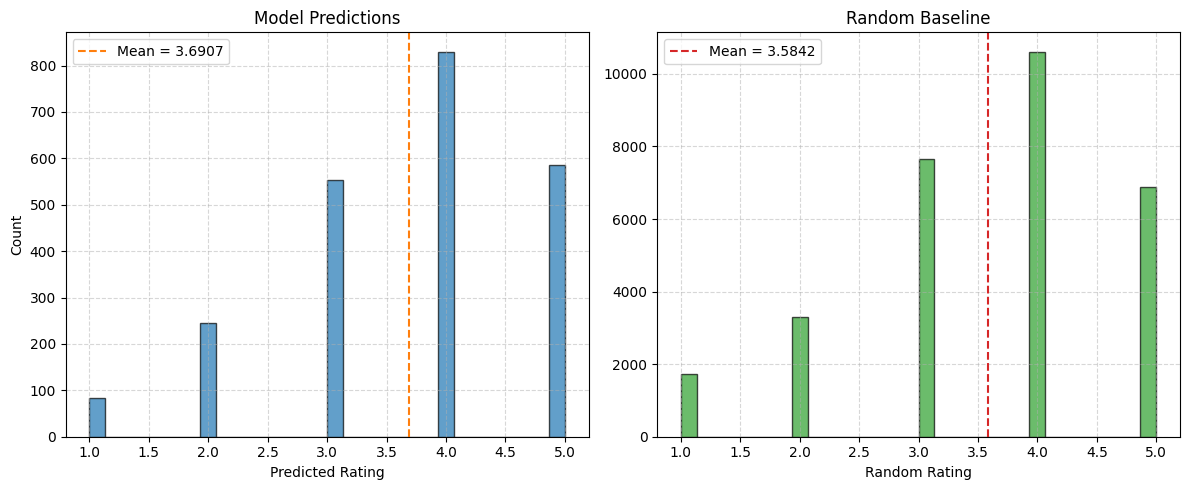

In [25]:
# Use an independent y-axis per subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Predictions histogram
axes[0].hist(ratings, bins=30, color='C0', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(ratings), color='C1', linestyle='--', label=f"Mean = {np.mean(ratings):.4f}")
axes[0].set_title('Model Predictions')
axes[0].set_xlabel('Predicted Rating')  # x-label
axes[0].set_ylabel('Count')             # y-label

# Random baseline histogram
axes[1].hist(random_seen, bins=30, color='C2', alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(random_seen), color='C3', linestyle='--', label=f"Mean = {np.mean(random_seen):.4f}")
axes[1].set_title('Random Baseline')
axes[1].set_xlabel('Random Rating')     # x-label

# Add legends and improve layout
for ax in axes:
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Target = True

In [26]:
ratings, unknown, random_seen = test_actor(actor, dg.train, embeddings, dict_embeddings, ra_length, history_length, target=True, nb_rounds=2)
print('%0.1f%% unknown' % (100 * unknown / (len(ratings) + unknown)))

86.0% unknown


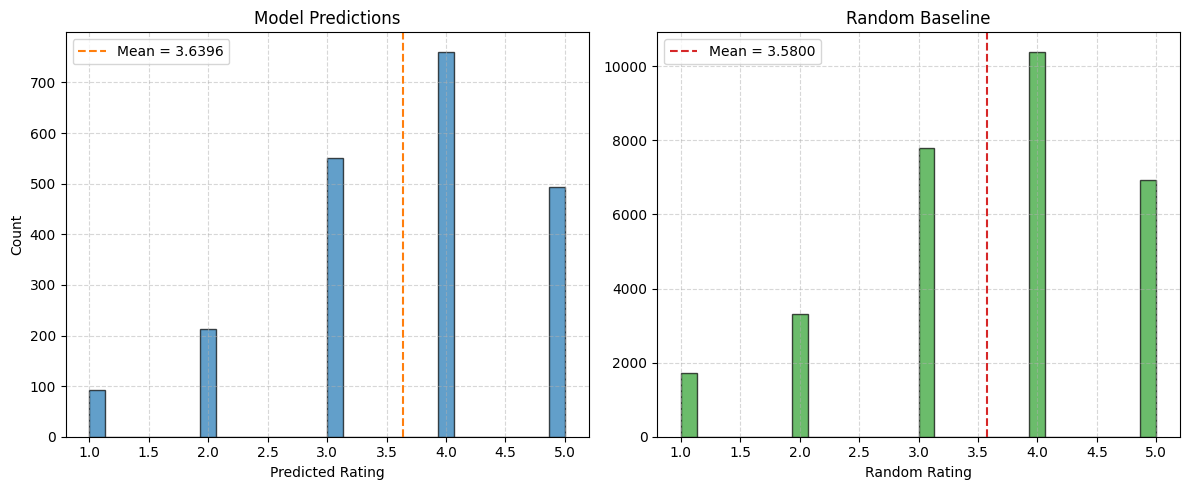

In [27]:
# Use an independent y-axis per subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Predictions histogram
axes[0].hist(ratings, bins=30, color='C0', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(ratings), color='C1', linestyle='--', label=f"Mean = {np.mean(ratings):.4f}")
axes[0].set_title('Model Predictions')
axes[0].set_xlabel('Predicted Rating')  # x-label
axes[0].set_ylabel('Count')             # y-label

# Random baseline histogram
axes[1].hist(random_seen, bins=30, color='C2', alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(random_seen), color='C3', linestyle='--', label=f"Mean = {np.mean(random_seen):.4f}")
axes[1].set_title('Random Baseline')
axes[1].set_xlabel('Random Rating')     # x-label

# Add legends and improve layout
for ax in axes:
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Test Set

Target = False

In [28]:
ratings, unknown, random_seen = test_actor(actor, dg.test, embeddings, dict_embeddings, ra_length, history_length, target=False, nb_rounds=1)
print('%0.1f%% unknown' % (100 * unknown / (len(ratings) + unknown)))

84.0% unknown


Comparison between the actual predictions made by the model and the randomly generated predictions

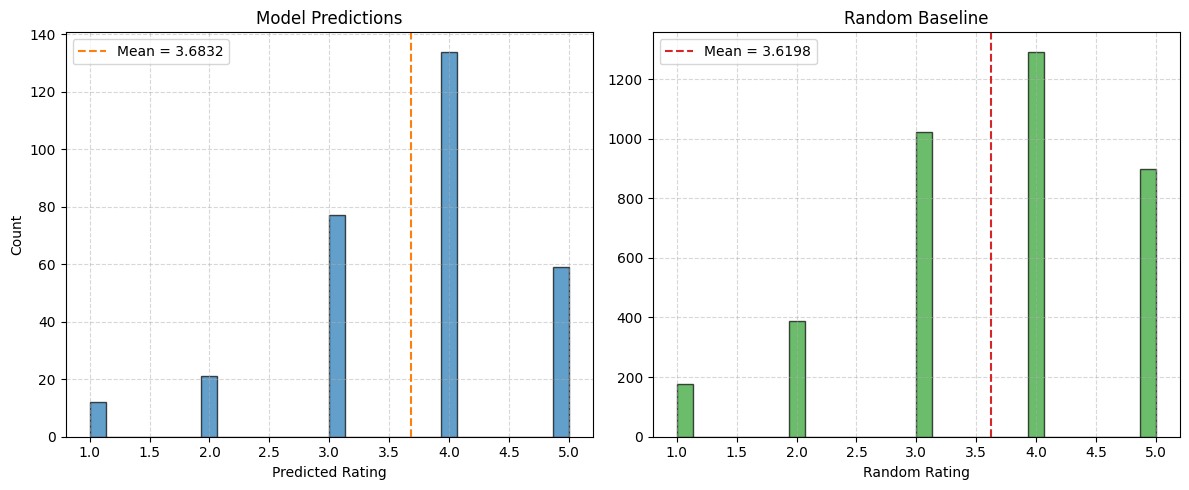

In [30]:
# Use an independent y-axis per subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Predictions histogram
axes[0].hist(ratings, bins=30, color='C0', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(ratings), color='C1', linestyle='--', label=f"Mean = {np.mean(ratings):.4f}")
axes[0].set_title('Model Predictions')
axes[0].set_xlabel('Predicted Rating')  # x-label
axes[0].set_ylabel('Count')             # y-label

# Random baseline histogram
axes[1].hist(random_seen, bins=30, color='C2', alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(random_seen), color='C3', linestyle='--', label=f"Mean = {np.mean(random_seen):.4f}")
axes[1].set_title('Random Baseline')
axes[1].set_xlabel('Random Rating')     # x-label

# Add legends and improve layout
for ax in axes:
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Target = True

In [31]:
ratings, unknown, random_seen = test_actor(actor, dg.test, embeddings, dict_embeddings, ra_length, history_length, target=True, nb_rounds=2)
print('%0.1f%% unknown' % (100 * unknown / (len(ratings) + unknown)))

85.7% unknown


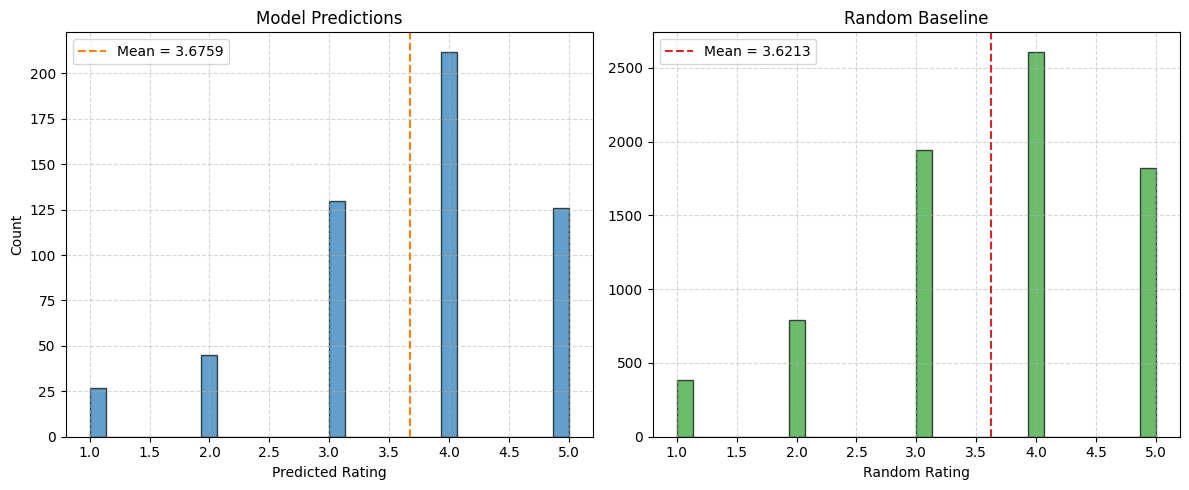

In [33]:
# Use an independent y-axis per subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Predictions histogram
axes[0].hist(ratings, bins=30, color='C0', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(ratings), color='C1', linestyle='--', label=f"Mean = {np.mean(ratings):.4f}")
axes[0].set_title('Model Predictions')
axes[0].set_xlabel('Predicted Rating')  # x-label
axes[0].set_ylabel('Count')             # y-label

# Random baseline histogram
axes[1].hist(random_seen, bins=30, color='C2', alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(random_seen), color='C3', linestyle='--', label=f"Mean = {np.mean(random_seen):.4f}")
axes[1].set_title('Random Baseline')
axes[1].set_xlabel('Random Rating')     # x-label

# Add legends and improve layout
for ax in axes:
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### Ranking Metrics Evaluation

In [34]:
# --- ranking metrics ---
def precision_at_k(rec, relevant, k):
    return len(set(rec[:k]) & set(relevant)) / k

def recall_at_k(rec, relevant, k):
    return len(set(rec[:k]) & set(relevant)) / len(relevant) if relevant else 0.0

def dcg_at_k(rec, rel_scores, k):
    """
    rec: list of itemIDs
    rel_scores: dict[itemID] -> rating 
    """
    dcg = 0.0
    for i, item in enumerate(rec[:k]):
        rel = rel_scores.get(item, 0)
        dcg += (2**rel - 1) / np.log2(i + 2)
    return dcg

def idcg_at_k(rel_scores, k):
    # ideal DCG from sorting true ratings
    sorted_rels = sorted(rel_scores.values(), reverse=True)[:k]
    idcg = sum((2**r - 1) / np.log2(i + 2) 
               for i, r in enumerate(sorted_rels))
    return idcg

def ndcg_at_k(rec, rel_scores, k):
    idcg = idcg_at_k(rel_scores, k)
    return dcg_at_k(rec, rel_scores, k) / idcg if idcg > 0 else 0.0

def average_precision(rec, relevant):
    hits = 0
    sum_prec = 0.0
    for i, item in enumerate(rec):
        if item in relevant:
            hits += 1
            sum_prec += hits / (i + 1)
    return sum_prec / len(relevant) if relevant else 0.0

# --- full test loop ---
def evaluate(actor, test_df, embeddings, dict_embeddings,
             ra_length, history_length, rating_threshold=4):
    P, R, NDCG, AP = [], [], [], []
    for user_df in test_df:
        # 1) build user history & true set
        hist = list(user_df.sample(history_length)['itemId'])
        true_ratings = user_df.set_index('itemId')['rating'].to_dict()
        relevant = [i for i, r in true_ratings.items() if r >= rating_threshold]
        
        # 2) get recommendations from your actor
        state_emb = embeddings.embed(hist)  # flatten & embed history
        recs = state_to_items(
            state_emb, actor, ra_length, embeddings, dict_embeddings, target=False
        )
        
        # 3) compute metrics
        P.append(precision_at_k(recs, relevant, ra_length))
        R.append(recall_at_k(recs, relevant, ra_length))
        NDCG.append(ndcg_at_k(recs, true_ratings, ra_length))
        AP.append(average_precision(recs, relevant))
    
    return {
        'Precision@K': np.mean(P),
        'Recall@K':    np.mean(R),
        'NDCG@K':      np.mean(NDCG),
        'MAP':         np.mean(AP),
    }

# --- run it ---
metrics = evaluate(
    actor,
    dg.test,           
    embeddings,
    dict_embeddings,
    ra_length,
    history_length,
    rating_threshold=4  # consider rating ≥4 as “relevant”
)

print(metrics)


{'Precision@K': np.float64(0.07513227513227512), 'Recall@K': np.float64(0.020245055313479223), 'NDCG@K': np.float64(0.08790119735508654), 'MAP': np.float64(0.011428827731267951)}
